<a href="https://colab.research.google.com/github/g-tumwesigye/sentiment_analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - Group Assignment
**Group Members**

John Deng Madit Akech

Makuach Teny Gatluak

Geofrey Tumwesigye

Peris Nyawira Wangui  


# Sentiment Analysis on IMDB Movie Reviews
# This notebook performs binary sentiment classification (positive/negative) using the IMDB 50K Movie Review Dataset.


In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Loading the dataset
file_path = "/content/IMDB Dataset.csv"
df = pd.read_csv(file_path, engine='python', on_bad_lines='warn')
df.head()

<ipython-input-4-0b4520d37dc6>:3: ParserWarning: Skipping line 16604: unexpected end of data

  df = pd.read_csv(file_path, engine='python', on_bad_lines='warn')


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Checking for missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Checking for empty strings
empty_reviews = (df['review'].str.strip() == '').sum()
empty_sentiments = (df['sentiment'].str.strip() == '').sum()
print(f"\nEmpty reviews: {empty_reviews}")
print(f"Empty sentiments: {empty_sentiments}")


Missing values per column:
 review       0
sentiment    0
dtype: int64

Empty reviews: 0
Empty sentiments: 0


### Missing values and empty strings handling
With the above codecell we checked for missing values and empty strings in both the `review` and `sentiment` columns to ensure that the dataset was clean.

**Results**:
- No missing values were found.
- No empty strings were detected.
- The dataset is complete and does not require dropping any rows.

# Exploratory Data Analysis (EDA)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16602 entries, 0 to 16601
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     16602 non-null  object
 1   sentiment  16602 non-null  object
dtypes: object(2)
memory usage: 259.5+ KB


<ipython-input-6-adc3e4fde0e7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


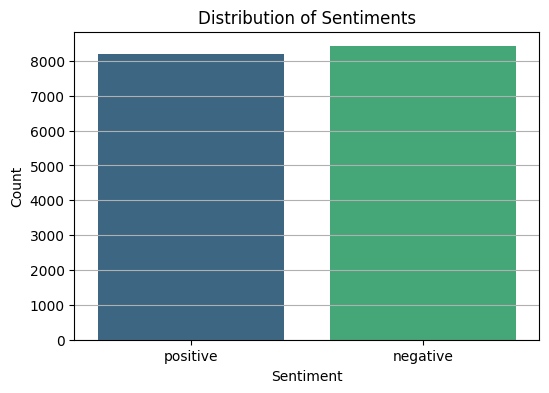

In [6]:
# Display dataset info & shape
df.info()
df.shape


# Checking class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


### Sentiment Distribution

The dataset is balanced, with an equal number of **positive** and **negative** reviews (25,000 each).There is no class imbalance.


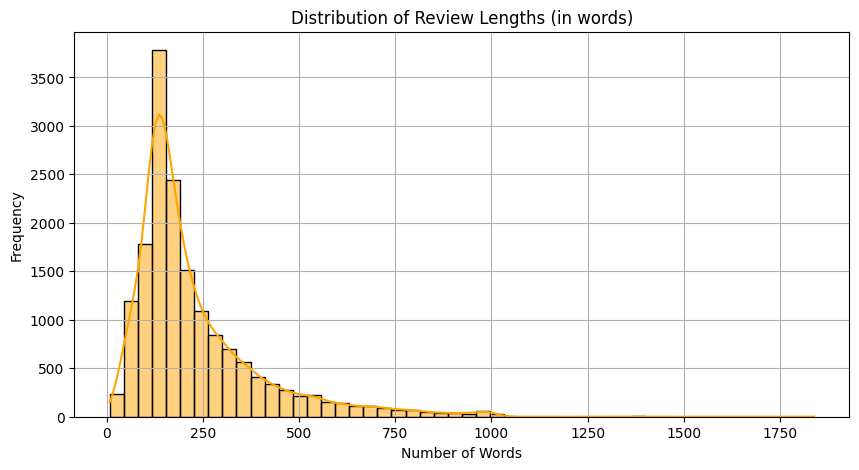

count    16602.000000
mean       231.468859
std        171.985724
min          8.000000
25%        126.000000
50%        172.000000
75%        282.000000
max       1839.000000
Name: review_length, dtype: float64


In [7]:
# Adding a column for review length
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Plott distribution of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=50, kde=True, color='orange')
plt.title("Distribution of Review Lengths (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid()
plt.show()

print(df['review_length'].describe())


### Review Length Distribution

Most reviews fall between 100 and 300 words. This insight helps us determine appropriate padding lengths when using neural networks and may inform choices around truncation or padding.

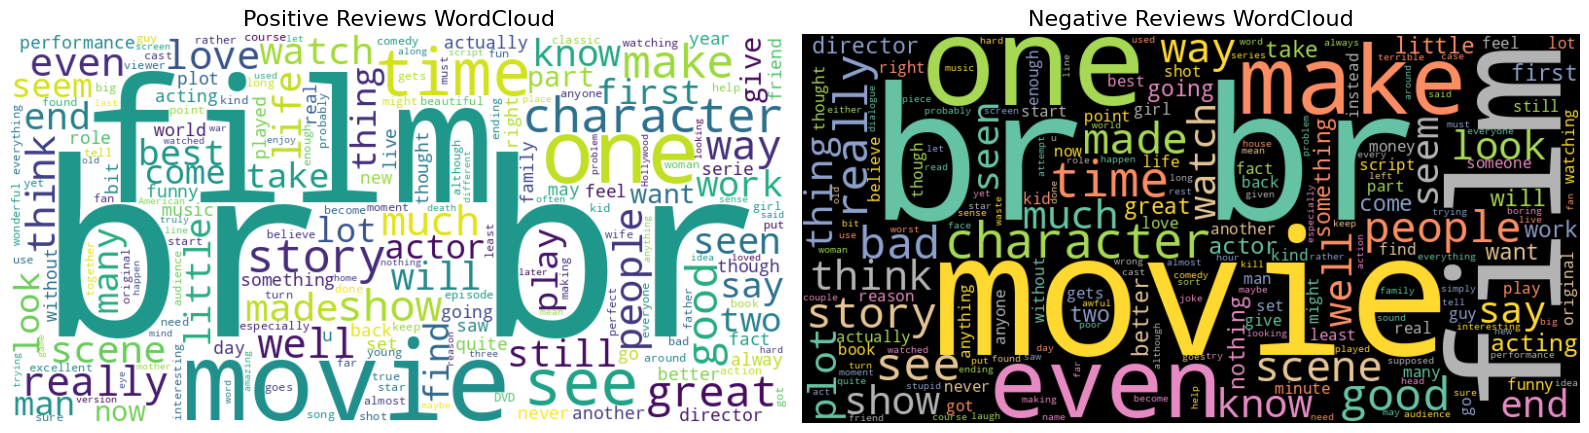

In [8]:
# Separating positive and negative reviews
pos_reviews = df[df['sentiment'] == 'positive']['review']
neg_reviews = df[df['sentiment'] == 'negative']['review']

# Generating Word Clouds
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(' '.join(pos_reviews))
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(' '.join(neg_reviews))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(wordcloud_pos, interpolation='bilinear')
axs[0].set_title('Positive Reviews WordCloud', fontsize=16)
axs[0].axis('off')

axs[1].imshow(wordcloud_neg, interpolation='bilinear')
axs[1].set_title('Negative Reviews WordCloud', fontsize=16)
axs[1].axis('off')

plt.tight_layout()
plt.show()


<ipython-input-9-911073b48375>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=common_df, palette='magma')


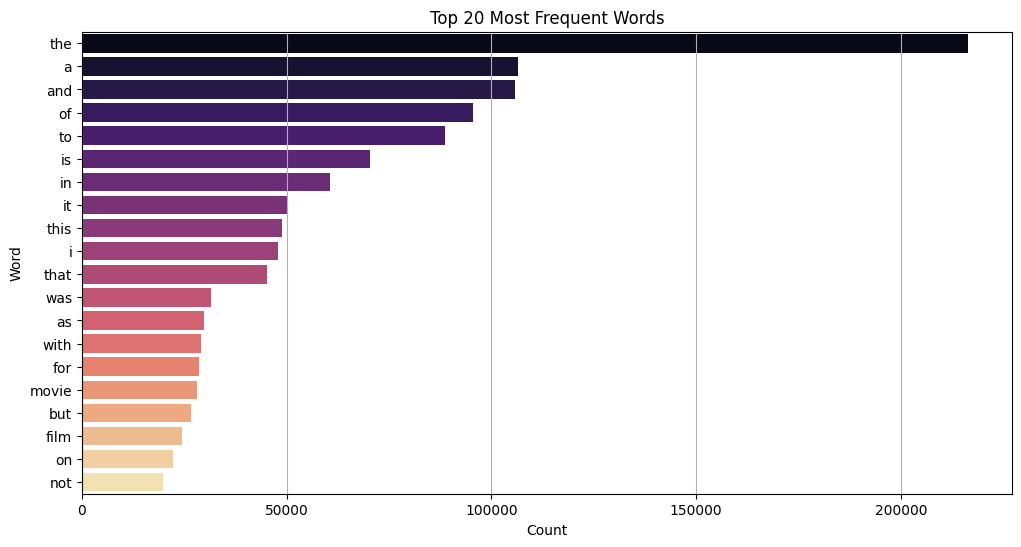

In [9]:
#  Most Common Words
# removing HTML tags & keeping only letters & spaces

from collections import Counter
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

# Cleaning and tokenizing
df['cleaned'] = df['review'].apply(clean_text)
all_words = ' '.join(df['cleaned']).split()
word_counts = Counter(all_words)

# Getting 20 most common words
most_common_words = word_counts.most_common(20)

# Converting to DataFrame for plotting
common_df = pd.DataFrame(most_common_words, columns=['word', 'count'])

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='word', data=common_df, palette='magma')
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.grid(axis='x')
plt.show()


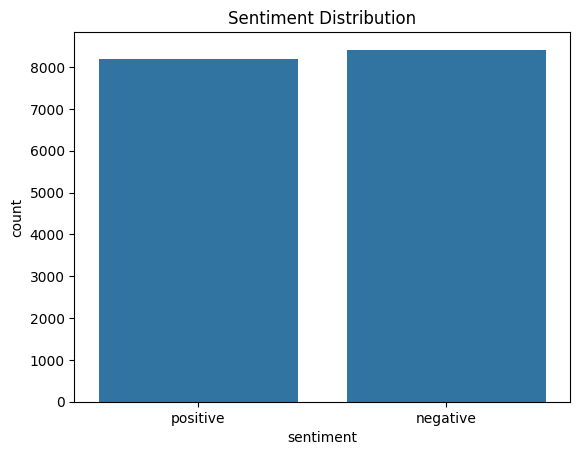

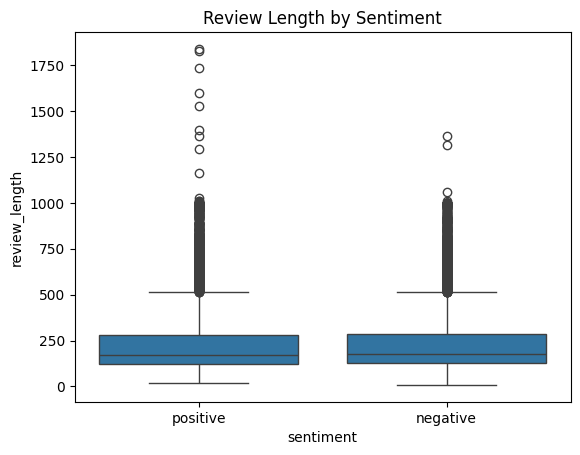

In [10]:
# Countplot of sentiments
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

# Boxplot of review lengths by sentiment
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.show()

# Text preprocessing & feature engineering



In [11]:
# Cleaning text, removing stopwords and preparing input features.

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [12]:
# Applying cleaning
import nltk

# Downloading the required resource
try:
    nltk.data.find('tokenizers/punkt_tab/english/')
except LookupError:
    nltk.download('punkt_tab')

# Cleaning the text function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [13]:
# Encoding labels and splitting data

df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
X = df['cleaned_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
 # Model 1 – Logistic Regression with TF-IDF

 # TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [15]:
# Training the logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [16]:
# Predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

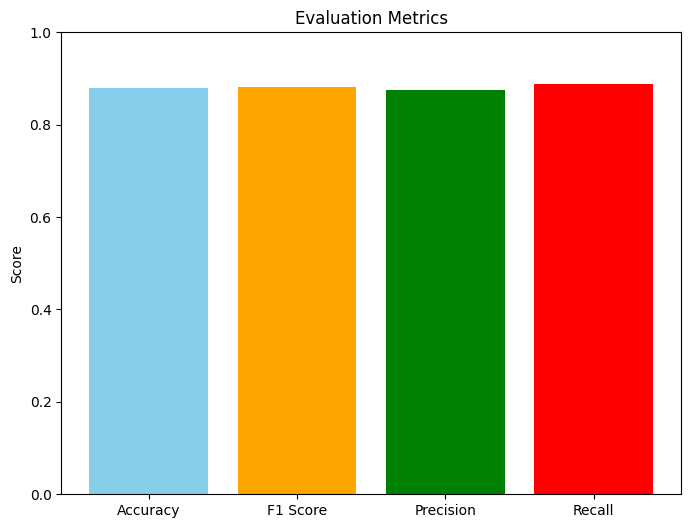

Accuracy: 0.8801565793435712
F1 Score: 0.8818289786223278
[[1438  212]
 [ 186 1485]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1650
           1       0.88      0.89      0.88      1671

    accuracy                           0.88      3321
   macro avg       0.88      0.88      0.88      3321
weighted avg       0.88      0.88      0.88      3321



In [17]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)

# Visualize the metrics using a bar plot
metrics = {'Accuracy': accuracy, 'F1 Score': f1, 'Precision': precision, 'Recall': recall}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

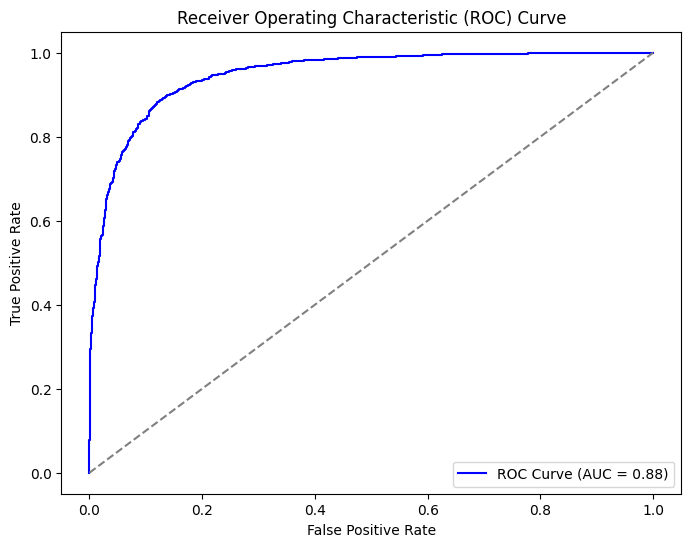

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test_tfidf)[:, 1])
auc = roc_auc_score(y_test, y_pred_lr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label='ROC Curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

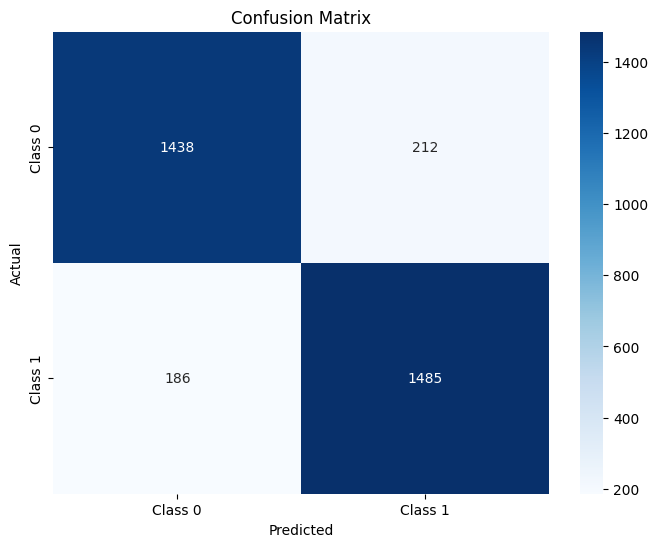

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
# Let's tune using GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [21]:
# Logistic Regression model
lr_model = LogisticRegression()

# Hyperparameter grid for GridSearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],  # Solvers to try
    'penalty': ['l2', 'l1'],  # Regularization type
}

# GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fitting GridSearchCV on training data
grid_search.fit(X_train_tfidf, y_train)

# Printing the best parameters and best score
print("Best Hyperparameters from GridSearchCV:", grid_search.best_params_)
print("Best Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Hyperparameters from GridSearchCV: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.8779


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solve

In [22]:
# Get the best model
best_lr_model = grid_search.best_estimator_

# Evaluate the best model on test data
y_pred_lr_tuned = best_lr_model.predict(X_test_tfidf)

# Metrics for the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_lr_tuned)
f1_tuned = f1_score(y_test, y_pred_lr_tuned)
precision_tuned = precision_score(y_test, y_pred_lr_tuned)
recall_tuned = recall_score(y_test, y_pred_lr_tuned)

# Printing the evaluation metrics for the tuned model
print("\nTuned Model Evaluation:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"F1 Score: {f1_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")



Tuned Model Evaluation:
Accuracy: 0.8802
F1 Score: 0.8818
Precision: 0.8751
Recall: 0.8887


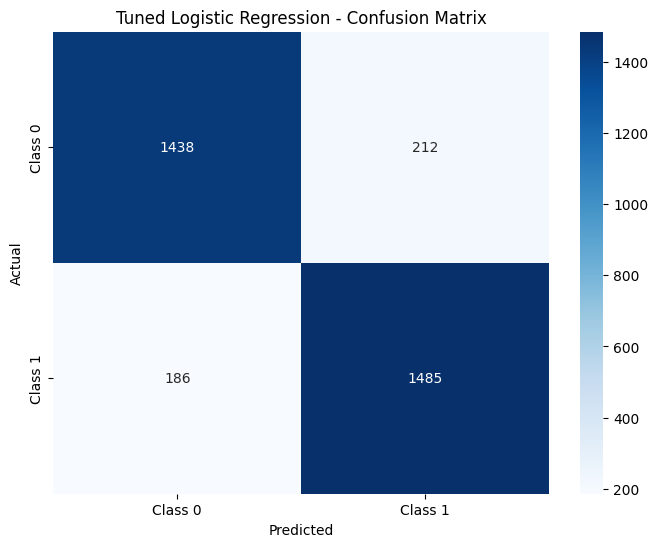

In [23]:
# Plotting confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_lr_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



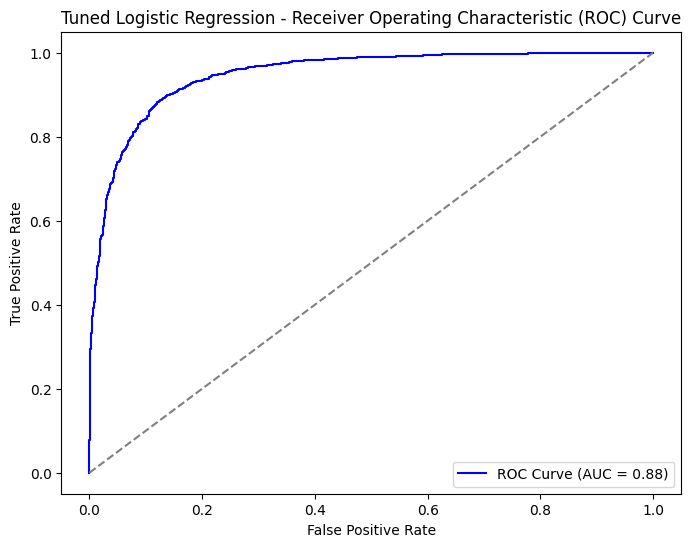

In [24]:
# ROC Curve
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, best_lr_model.predict_proba(X_test_tfidf)[:, 1])
auc_tuned = roc_auc_score(y_test, y_pred_lr_tuned)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='b', label='ROC Curve (AUC = %0.2f)' % auc_tuned)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Tuned Logistic Regression - Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Training the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_train_nb = nb_model.predict(X_train_tfidf)
y_pred_test_nb = nb_model.predict(X_test_tfidf)


Naive Bayes Model Evaluation
Training Accuracy: 0.8817860100896017
Testing Accuracy: 0.8533574224631135

Confusion Matrix:
[[1415  235]
 [ 252 1419]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1650
           1       0.86      0.85      0.85      1671

    accuracy                           0.85      3321
   macro avg       0.85      0.85      0.85      3321
weighted avg       0.85      0.85      0.85      3321



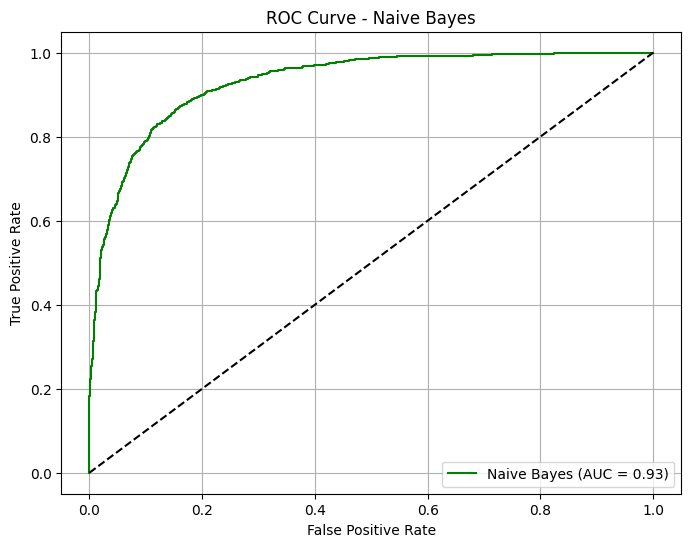

In [26]:
# Evaluation Metrics
print("Naive Bayes Model Evaluation")
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_nb))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test_nb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_test_nb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test_nb))

# 4. ROC Curve and AUC
y_probs_nb = nb_model.predict_proba(X_test_tfidf)[:, 1]
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_probs_nb)
auc_nb = roc_auc_score(y_test, y_probs_nb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



Confusion Matrix:


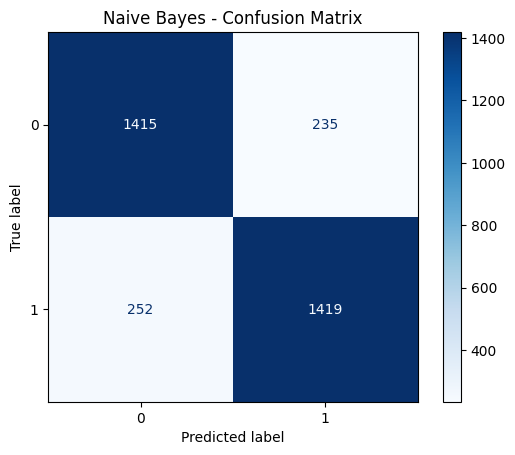

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes - Confusion Matrix")
plt.show()